In [3]:
# import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from scripts import download, assets

In [ ]:
# Yahoo financial
download.updateShortPeriodData()

In [6]:
# Yahoo financial
download.download30mdata('ZM')

[*********************100%***********************]  1 of 1 completed
Saved ZM 30 minute interval data.


In [2]:
# Yahoo financial
data = yf.download('TSLA', start='2023-02-09', end='2023-03-09', interval='5m')
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


In [2]:
tsla = assets.Equity('TSLA', threshold=0.02, duration=2, thr_grad=0.01)
print(tsla)

symbol: TSLA, thresholds: (0.03, 0.03), duration: 2, gradient_threshold: 0.01, rebound: 0, limit: 1000, release_threshold: 0.03, release_rebound: 0.


In [5]:
tsla.save('./data/setting_data')

In [3]:
tsla.load('./data/setting_data')
print(tsla)

symbol: TSLA, thresholds: (0.1, 0.1), duration: 2, gradient_threshold: 0.02, rebound: 0, limit: 1000, release_threshold: 0.1, release_rebound: 0.


In [124]:
data = pd.read_csv('./data/market_data/alpaca_data/TSLA.csv', index_col=0)
data

,OpenPrice,HighPrice,LowPrice,ClosePrice,Volume
Timestamp,,,,,
2020-03-16T08:00:00Z,506.50,506.50,472.01,474.99,81191
2020-03-16T08:30:00Z,475.00,479.88,472.00,476.00,30570
2020-03-16T09:00:00Z,475.35,477.50,474.24,476.98,7833
2020-03-16T09:30:00Z,476.72,481.64,476.72,476.73,11988
2020-03-16T10:00:00Z,476.99,478.50,473.00,473.00,22110
...,...,...,...,...,...
2023-03-17T21:30:00Z,180.00,180.13,179.60,179.75,282207
2023-03-17T22:00:00Z,179.76,179.80,179.35,179.50,44893
2023-03-17T22:30:00Z,179.45,179.59,179.41,179.50,11054


In [ ]:
# Getting-position algorithm
ts_data = data.OpenPrice[:5000]
ts_time = data.index[:5000]
buying_points = []
selling_points = []
almost_points = []
tsla = assets.Equity('TSLA', threshold=0.03, duration=2, thr_grad=0.01)
start_time = 0
for i in range(1, len(ts_data)):
    buy_diff_thr = ts_data[start_time] * tsla.thr_buy
    sell_diff_thr = ts_data[start_time] * tsla.thr_sell
    bool_diff = ts_data[start_time] - buy_diff_thr > ts_data[i] or ts_data[start_time] + sell_diff_thr < ts_data[i]
    bool_dur = (i - start_time) / 12 >= tsla.dur
    bool_grad = abs(ts_data[start_time] - ts_data[i]) / (i - start_time) * 12 > ts_data[start_time] * tsla.thr_grad

    if bool_diff and bool_dur and bool_grad:
        almost_points.append(i)
        # print(i, (ts_data[i] - ts_data[i - 2]), ts_data[start_time], (ts_data[i] - ts_data[i - 2]) / ts_data[start_time])
        if ts_data[i] < ts_data[start_time]:
            bool_rebound = -0.005 + tsla.reb < (ts_data[i] - ts_data[i - 2]) / ts_data[start_time]
            if bool_rebound:
                buying_points.append((ts_time[i], ts_data[i]))
                start_time = i
        else:
            bool_rebound = (ts_data[i] - ts_data[i - 2]) / ts_data[start_time] < 0.005 + tsla.reb
            if bool_rebound:
                selling_points.append((ts_time[i], ts_data[i]))
                start_time = i

    if (i - start_time) / 12 >= tsla.dur * 2 and not bool_grad:
        start_time = i

In [8]:
# Releasing-position algorithm
exit_points = []
for point, buying_price in buying_points:
    curr = ts_time.get_loc(point)
    while curr < len(ts_data):
        if ts_data[curr] > buying_price * (1 + 0.01):
            bool_rebound = (ts_data[curr] - ts_data[curr - 8]) / buying_price < 0.005 + tsla.reb
            if bool_rebound:
                exit_points.append((ts_time[curr], ts_data[curr]))
                break
        curr += 1

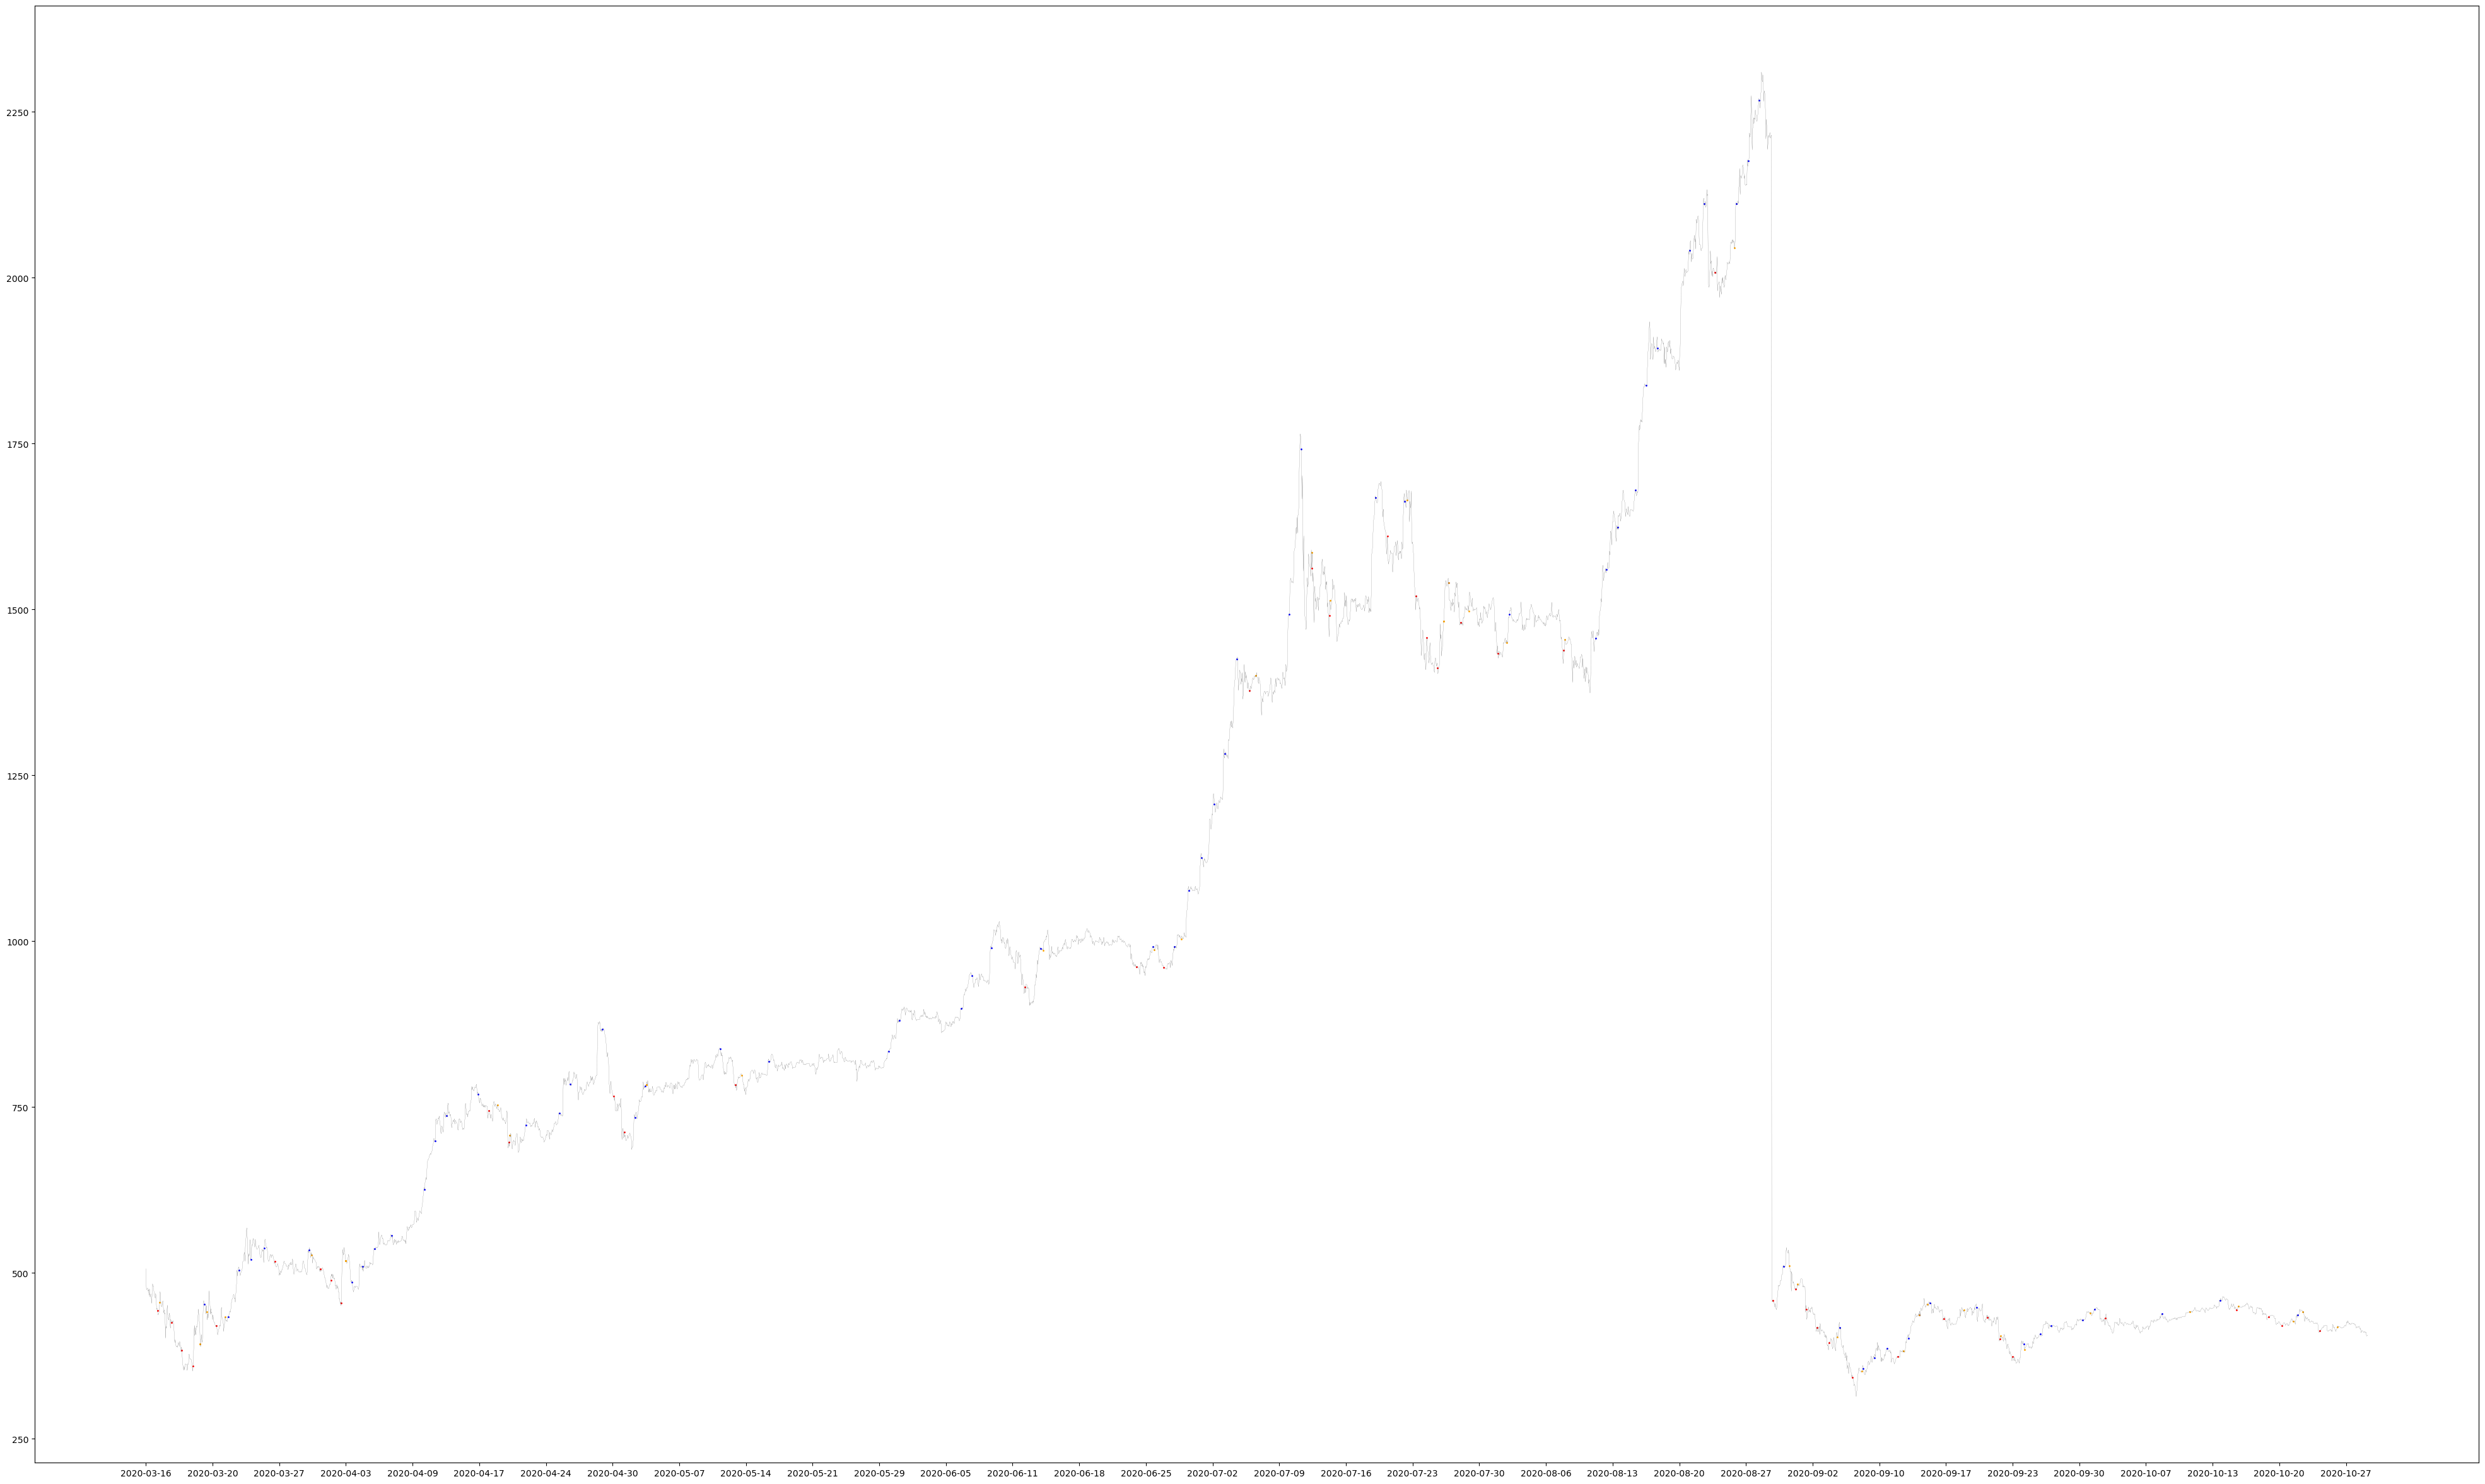

In [10]:
#%matplotlib notebook
%matplotlib inline

from scripts import utils

utils.visualize(ts_time, ts_data, buying_points, selling_points, exit_points)

In [4]:
from scripts import assets

In [38]:
tsla = assets.Equity_Manual_v1('TSLA')

In [39]:
import numpy as np

def get_new_position(asset, test_end_point = 0):
  data_np = np.array(asset.data['OpenPrice'])

  if test_end_point != 0:
    data_np = data_np[:test_end_point + 1]

  current_price = data_np[-1]

  data_np = data_np[max(-(len(data_np) - asset.start_point), -(1 + asset.settings['duration'])):-1]

  min_price = np.min(data_np)
  max_price = np.max(data_np)

  thr_buy_sig_on = (1 - asset.settings['thr_buy']) * max_price >= current_price
  reb_buy_sig_on = (1 + asset.settings['rebound']) * data_np[-1] <= current_price
  thr_sell_sig_on = (1 + asset.settings['thr_sell']) * min_price <= current_price
  reb_sell_sig_on = (1 - asset.settings['rebound']) * data_np[-1] >= current_price

  if (thr_buy_sig_on and reb_buy_sig_on) or (thr_sell_sig_on and reb_sell_sig_on):
    asset.start_point = len(asset.data['OpenPrice']) - 2 if test_end_point == 0 else test_end_point

  return thr_buy_sig_on and reb_buy_sig_on, thr_sell_sig_on and reb_sell_sig_on

In [40]:
ts_time = tsla.data['Timestamp']
ts_data = tsla.data['OpenPrice']

buying = []
selling = []

for i in range(1, 24335):
  result = get_new_position(tsla, i)
  if result != (False, False):
    if result[0]:
      buying.append((i, ts_data[i]))
    else:
      selling.append((i, ts_data[i]))

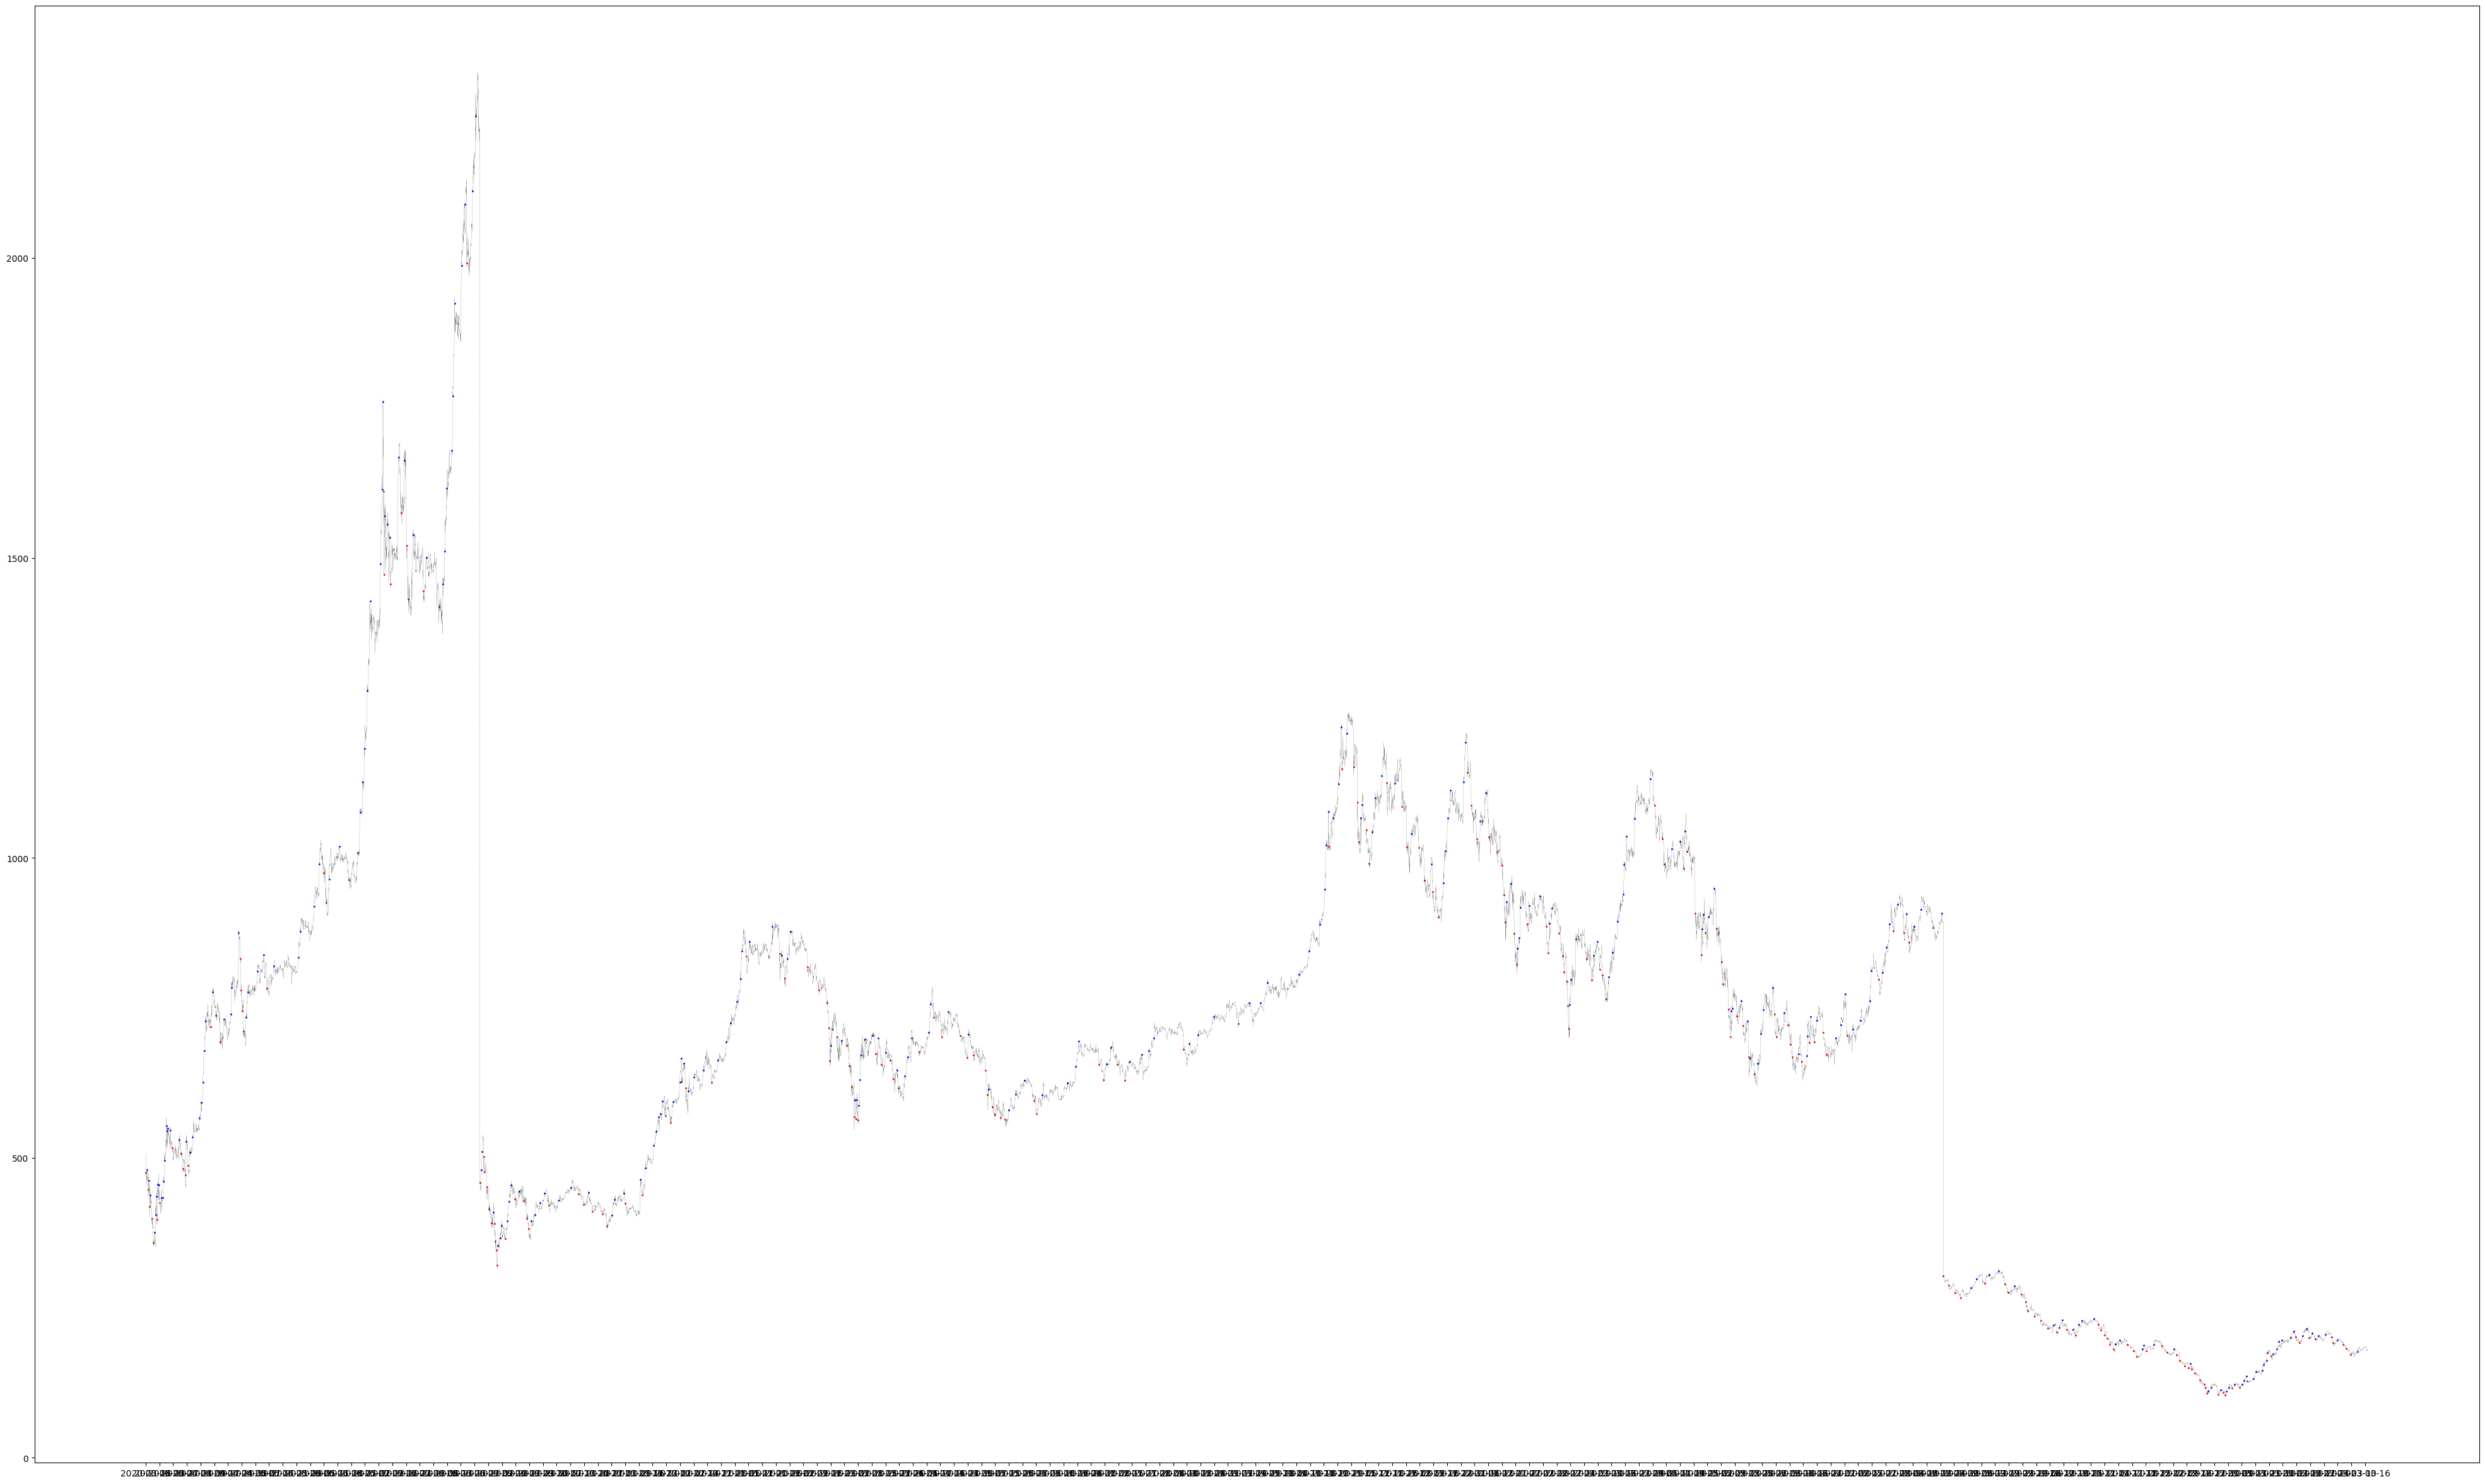

In [41]:
#%matplotlib notebook
%matplotlib inline

from scripts import utils

utils.visualize(ts_time, ts_data, buying, selling, [])

In [111]:
tsla.check_data()

False

In [89]:
get_new_position(tsla, 0)

[174.07000732 174.27000427 174.78999329 175.44999695 175.36999512
 174.91000366 174.61000061 177.30999756 180.86999512 180.97000122
 181.05999756 180.44000244 180.28500366 180.53500366 179.5
 179.58999634 180.56869507 180.24000549 181.25999451 181.50259399
 180.58999634 179.88960266 179.96499634 180.36000061 180.36999512
 179.19189453 179.49960327 179.94000244 180.50999451 180.72000122
 180.88000488 180.51499939 180.67999268 181.6000061  181.55659485
 180.8999939  181.44000244 181.53999329 181.1499939  181.58000183
 181.8500061  181.61999512 181.50999451 181.61999512 182.97129822
 183.48500061 182.75999451 183.25       183.1499939  182.90409851
 183.57000732 182.6625061  182.30999756 181.91999817 182.22009277
 182.60519409 182.26300049 182.88130188 182.11999512 182.25
 182.36999512 182.19999695 181.77000427 181.50999451 181.76010132
 181.25       181.         181.44999695 181.66119385 181.85009766
 181.86250305 181.956604   181.60749817 181.23789978 181.64500427
 180.71000671 180.19000

(False, True)

In [122]:
tsla.data

,Datetime,Open,High,Low,Close,Adj Close,Volume
0,2023-02-16 09:30:00-05:00,210.779999,211.970001,209.360001,210.479996,210.479996,13422956
1,2023-02-16 09:35:00-05:00,210.440002,211.889999,208.309998,211.705505,211.705505,5339944
2,2023-02-16 09:40:00-05:00,211.729904,212.830002,210.880005,212.149994,212.149994,5421561
3,2023-02-16 09:45:00-05:00,212.149994,213.659805,211.410004,212.681000,212.681000,4311607
4,2023-02-16 09:50:00-05:00,212.669998,215.289993,212.229996,214.800095,214.800095,5292102
...,...,...,...,...,...,...,...
1555,2023-03-16 15:35:00-04:00,184.649994,184.666794,183.770004,184.167603,184.167603,1537491
1556,2023-03-16 15:40:00-04:00,184.154999,184.550003,184.050003,184.419998,184.419998,1054065
1557,2023-03-16 15:45:00-04:00,184.410004,184.419998,183.860001,184.039993,184.039993,1197983
1558,2023-03-16 15:50:00-04:00,184.039993,184.300003,183.960007,184.009995,184.009995,1166237


In [16]:
import requests
import os
from dotenv import load_dotenv

load_dotenv(verbose=True)

baseurl = os.getenv('ALPACA_PAPER_BASEURL')

headers = {
  'accept': 'application/json',
  'APCA-API-KEY-ID': os.getenv('ALPACA_PAPER_KEY'),
  'APCA-API-SECRET-KEY': os.getenv('ALPACA_PAPER_KEY_SECRET'),
}

response = requests.get(baseurl + '/account', headers=headers).json()

response['buying_power']

'399482.08'

In [19]:
response = requests.get(baseurl + '/positions', headers=headers).json()

{r['symbol']: r['qty'] for r in response if r['side'] == 'long'}

{'AAPL': '2', 'MSFT': '1'}

In [23]:
headers = {
  'accept': 'application/json',
  'content-type': 'application/json',
  'APCA-API-KEY-ID': os.getenv('ALPACA_PAPER_KEY'),
  'APCA-API-SECRET-KEY': os.getenv('ALPACA_PAPER_KEY_SECRET'),
}

payload = {
  'side': 'sell',
  'type': 'market',
  'time_in_force': 'day',
  'symbol': 'AAPL',
  'qty': 2,
}

response = requests.post(baseurl + '/orders', json=payload, headers=headers).json()

response

{'id': 'cce49ef8-02a5-4e7c-bd95-dabd29557734',
 'client_order_id': '01ff3e4c-92d6-4c66-970f-9a0658040611',
 'created_at': '2023-09-08T01:07:27.712690917Z',
 'updated_at': '2023-09-08T01:07:27.712690917Z',
 'submitted_at': '2023-09-08T01:07:27.712125287Z',
 'filled_at': None,
 'expired_at': None,
 'canceled_at': None,
 'failed_at': None,
 'replaced_at': None,
 'replaced_by': None,
 'replaces': None,
 'asset_id': 'b0b6dd9d-8b9b-48a9-ba46-b9d54906e415',
 'symbol': 'AAPL',
 'asset_class': 'us_equity',
 'notional': None,
 'qty': '2',
 'filled_qty': '0',
 'filled_avg_price': None,
 'order_class': '',
 'order_type': 'market',
 'type': 'market',
 'side': 'sell',
 'time_in_force': 'day',
 'limit_price': None,
 'stop_price': None,
 'status': 'accepted',
 'extended_hours': False,
 'legs': None,
 'trail_percent': None,
 'trail_price': None,
 'hwm': None,
 'subtag': None,
 'source': None}

In [24]:
payload = {
  'side': 'buy',
  'type': 'market',
  'time_in_force': 'day',
  'symbol': 'TSLA',
  'notional': 1000,
}

response = requests.post(baseurl + '/orders', json=payload, headers=headers).json()

response

{'id': 'b6e85ba2-3484-4d0a-a8a9-0e09387bf677',
 'client_order_id': '33638e9c-4703-4738-948b-1a8291c85531',
 'created_at': '2023-09-08T01:09:10.153212846Z',
 'updated_at': '2023-09-08T01:09:10.153212846Z',
 'submitted_at': '2023-09-08T01:09:10.152673796Z',
 'filled_at': None,
 'expired_at': None,
 'canceled_at': None,
 'failed_at': None,
 'replaced_at': None,
 'replaced_by': None,
 'replaces': None,
 'asset_id': '8ccae427-5dd0-45b3-b5fe-7ba5e422c766',
 'symbol': 'TSLA',
 'asset_class': 'us_equity',
 'notional': '1000',
 'qty': None,
 'filled_qty': '0',
 'filled_avg_price': None,
 'order_class': '',
 'order_type': 'market',
 'type': 'market',
 'side': 'buy',
 'time_in_force': 'day',
 'limit_price': None,
 'stop_price': None,
 'status': 'accepted',
 'extended_hours': False,
 'legs': None,
 'trail_percent': None,
 'trail_price': None,
 'hwm': None,
 'subtag': None,
 'source': None}